<a href="https://colab.research.google.com/github/Ariyamilaara/2318105_DataCleansing/blob/main/2318105DataCleansing.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Import Libary**


Bagian ini digunakan untuk memanggil library utama yang mendukung proses analisis data. pandas dipakai untuk membaca dan mengolah dataset dalam bentuk tabel, matplotlib.pyplot digunakan untuk membuat grafik, sedangkan seaborn membantu membuat visualisasi data yang lebih rapi dan mudah dibaca.

In [ ]:
!pip install --upgrade pandas numpy matplotlib seaborn openpyxl fuzzywuzzy[speedup] python-Levenshtein

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import re
from fuzzywuzzy import process, fuzz

# Atur tampilan pandas
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', 50)

# **Membaca Dataset**

Kode ini berfungsi untuk membuka dataset CSV COVID-19 dan menampilkan ukuran data serta lima baris pertama. Dengan cara ini kita bisa memastikan bahwa dataset berhasil terbaca dengan benar dan sekaligus mendapatkan gambaran awal tentang isi data mentah yang akan diproses.

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

# lalu arahkan path ke file di Drive
file_path = "/content/drive/MyDrive/DATA_MINING/Covid_Live.csv" # ganti sesuai folder Anda

df_raw = pd.read_csv(file_path, low_memory=False)
print("Shape awal:", df_raw.shape)
df_raw.head()


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Shape awal: (230, 13)


,#,"Country,\nOther",Total\nCases,Total\nDeaths,New\nDeaths,Total\nRecovered,Active\nCases,"Serious,\nCritical",Tot Cases/\n1M pop,Deaths/\n1M pop,Total\nTests,Tests/\n1M pop,Population
0,1,USA,"98,166,904","1,084,282",NaN,"94,962,112","2,120,510","2,970","293,206","3,239","1,118,158,870","3,339,729","334,805,269"
1,2,India,"44,587,307","528,629",NaN,"44,019,095","39,583",698,"31,698",376,"894,416,853","635,857","1,406,631,776"
2,3,France,"35,342,950","155,078",NaN,"34,527,115","660,757",869,"538,892","2,365","271,490,188","4,139,547","65,584,518"
3,4,Brazil,"34,706,757","686,027",NaN,"33,838,636","182,094","8,318","161,162","3,186","63,776,166","296,146","215,353,593"
4,5,Germany,"33,312,373","149,948",NaN,"32,315,200","847,225","1,406","397,126","1,788","122,332,384","1,458,359","83,883,596"


# **Explorasi Awal**

Bagian ini berfungsi untuk memahami kondisi dataset sebelum dilakukan pembersihan. Perintah df_raw.info() digunakan untuk menampilkan informasi struktur dataset, termasuk jumlah baris, kolom, tipe data, dan apakah ada nilai kosong. Selanjutnya, df_raw.isna().sum() dipakai untuk menghitung jumlah nilai yang hilang (missing values) di setiap kolom, sehingga kita bisa mengetahui kolom mana yang perlu diperbaiki. Terakhir, df_raw.duplicated().sum() digunakan untuk mengecek jumlah baris duplikat yang ada dalam dataset. Dengan eksplorasi awal ini, kita mendapatkan gambaran kualitas data mentah dan menentukan langkah cleansing yang tepat.

In [ ]:
# Lihat info dataset
df_raw.info()

# Cek missing values
print("\nJumlah missing value per kolom:")
print(df_raw.isna().sum())

# Cek duplikat
print("\nJumlah baris duplikat:", df_raw.duplicated().sum())


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 230 entries, 0 to 229
Data columns (total 13 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   #                  230 non-null    int64  
 1   Country,
Other     230 non-null    object 
 2   Total
Cases        230 non-null    object 
 3   Total
Deaths       225 non-null    object 
 4   New
Deaths         3 non-null      float64
 5   Total
Recovered    214 non-null    object 
 6   Active
Cases       215 non-null    object 
 7   Serious,
Critical  147 non-null    object 
 8   Tot Cases/
1M pop  228 non-null    object 
 9   Deaths/
1M pop     223 non-null    object 
 10  Total
Tests        214 non-null    object 
 11  Tests/
1M pop      214 non-null    object 
 12  Population         228 non-null    object 
dtypes: float64(1), int64(1), object(11)
memory usage: 23.5+ KB

Jumlah missing value per kolom:
#                       0
Country,\nOther         0
Total\nCases            0


# **Standarisasi Nama Kolom**

Langkah ini bertujuan untuk merapikan nama kolom yang masih berisi karakter aneh seperti newline (\n), koma, dan spasi berlebih. Setelah dibersihkan, nama kolom diubah menjadi lebih sederhana, misalnya CountryOther menjadi Country, sehingga lebih konsisten dan mudah dipanggil dalam analisis selanjutnya.

In [ ]:
# Normalisasi nama kolom agar konsisten
df = df_raw.copy()
df.columns = [c.strip().replace(" ", "_").replace("/", "_per_") for c in df.columns]

print("Kolom setelah normalisasi:")
print(df.columns.tolist())


Kolom setelah normalisasi:
['#', 'Country,\nOther', 'Total\nCases', 'Total\nDeaths', 'New\nDeaths', 'Total\nRecovered', 'Active\nCases', 'Serious,\nCritical', 'Tot_Cases_per_\n1M_pop', 'Deaths_per_\n1M_pop', 'Total\nTests', 'Tests_per_\n1M_pop', 'Population']


# **Membersihkan Data Numerik**

Bagian ini dipakai untuk mengubah semua nilai angka yang masih berbentuk teks ke dalam tipe data numerik. Misalnya data "1,234,567" diubah menjadi 1234567. Selain itu, nilai kosong seperti N/A atau - juga dikonversi menjadi NaN agar bisa diproses dengan benar. Dengan begitu, dataset lebih bersih dan siap untuk analisis statistik.

In [ ]:
# Fungsi bantu untuk membersihkan angka
def to_num(x):
    if pd.isna(x):
        return np.nan
    s = str(x).strip()
    if s.upper() in ['N/A','NA','NONE','-','--','']:
        return np.nan
    s = s.replace(',', '').replace('+','')
    try:
        return float(s)
    except:
        s2 = re.sub(r'[^0-9eE\.\-]', '', s)
        try:
            return float(s2)
        except:
            return np.nan

# Terapkan fungsi pada semua kolom numerik
for col in df.columns:
    if col != "Country":  # asumsikan ada kolom Country
        df[col] = df[col].map(to_num)

df.head()


,#,"Country,\nOther",Total\nCases,Total\nDeaths,New\nDeaths,Total\nRecovered,Active\nCases,"Serious,\nCritical",Tot_Cases_per_\n1M_pop,Deaths_per_\n1M_pop,Total\nTests,Tests_per_\n1M_pop,Population
0,1.0,NaN,98166904.0,1084282.0,NaN,94962112.0,2120510.0,2970.0,293206.0,3239.0,1.118159e+09,3339729.0,3.348053e+08
1,2.0,NaN,44587307.0,528629.0,NaN,44019095.0,39583.0,698.0,31698.0,376.0,8.944169e+08,635857.0,1.406632e+09
2,3.0,NaN,35342950.0,155078.0,NaN,34527115.0,660757.0,869.0,538892.0,2365.0,2.714902e+08,4139547.0,6.558452e+07
3,4.0,NaN,34706757.0,686027.0,NaN,33838636.0,182094.0,8318.0,161162.0,3186.0,6.377617e+07,296146.0,2.153536e+08
4,5.0,NaN,33312373.0,149948.0,NaN,32315200.0,847225.0,1406.0,397126.0,1788.0,1.223324e+08,1458359.0,8.388360e+07


# **Standarisasi Nama Negara**

Kode ini berfungsi untuk menyeragamkan penulisan nama negara yang berbeda tetapi sebenarnya sama. Contohnya, USA diubah menjadi United States atau S. Korea diubah menjadi South Korea. Tujuannya agar data tidak terpecah dan tetap konsisten saat dilakukan perhitungan atau visualisasi.

In [ ]:
print(df.columns.tolist())


['#', 'Country,\nOther', 'Total\nCases', 'Total\nDeaths', 'New\nDeaths', 'Total\nRecovered', 'Active\nCases', 'Serious,\nCritical', 'Tot_Cases_per_\n1M_pop', 'Deaths_per_\n1M_pop', 'Total\nTests', 'Tests_per_\n1M_pop', 'Population']


In [ ]:
# Ganti nama kolom Country,Other → Country
df = df.rename(columns={"Country,\nOther": "Country"})

# Setelah itu baru lakukan mapping
manual_map = {
    "S. Korea": "South Korea",
    "UK": "United Kingdom",
    "UAE": "United Arab Emirates",
    "USA": "United States",
    "Viet Nam": "Vietnam",
    "Czechia": "Czech Republic"
}

df['Country'] = df['Country'].astype(str).str.strip()
df['Country'] = df['Country'].replace(manual_map)

print("Contoh nama negara unik:")
print(df['Country'].unique()[:30])


Contoh nama negara unik:
['nan']


Menghapus Duplikat

In [ ]:
print("Jumlah baris sebelum deduplikasi:", df.shape[0])

# Gabungkan data duplikat per Country → ambil nilai maksimum (karena sifatnya kumulatif)
num_cols = [c for c in df.columns if c != 'Country']
df = df.groupby('Country', as_index=False)[num_cols].max()

print("Jumlah baris sesudah deduplikasi:", df.shape[0])


Jumlah baris sebelum deduplikasi: 230
Jumlah baris sesudah deduplikasi: 1


Imputasi & Rekalkulasi Kolom

In [ ]:
# Hitung kembali kolom turunan jika ada
if 'TotalCases' in df.columns and 'TotalDeaths' in df.columns and 'TotalRecovered' in df.columns:
    df['ActiveCases_calc'] = df['TotalCases'] - df['TotalDeaths'] - df['TotalRecovered']
    # jika ActiveCases kosong, isi dengan hasil kalkulasi
    if 'ActiveCases' in df.columns:
        mask = df['ActiveCases'].isna()
        df.loc[mask, 'ActiveCases'] = df.loc[mask, 'ActiveCases_calc']
    else:
        df['ActiveCases'] = df['ActiveCases_calc']

# Contoh: TotCases_per_1M
if 'TotalCases' in df.columns and 'Population' in df.columns:
    mask = df['TotCases_per_1M'].isna() & df['TotalCases'].notna() & df['Population'].notna()
    df.loc[mask, 'TotCases_per_1M'] = df.loc[mask, 'TotalCases'] / (df.loc[mask, 'Population']/1_000_000)

df.drop(columns=['ActiveCases_calc'], errors='ignore', inplace=True)

print("Missing value setelah imputasi:")
print(df.isna().sum())


Missing value setelah imputasi:
Country                   0
#                         0
Total\nCases              0
Total\nDeaths             0
New\nDeaths               0
Total\nRecovered          0
Active\nCases             0
Serious,\nCritical        0
Tot_Cases_per_\n1M_pop    0
Deaths_per_\n1M_pop       0
Total\nTests              0
Tests_per_\n1M_pop        0
Population                0
dtype: int64


Validasi & Outlier Check

In [ ]:
# Bersihkan nama kolom dari newline dan koma
df.columns = df.columns.str.replace("\n", "", regex=True).str.replace(",", "", regex=True).str.strip()

# Rename ke nama standar yang lebih rapi
df = df.rename(columns={
    "Country Other": "Country",
    "TotalCases": "TotalCases",
    "TotalDeaths": "TotalDeaths",
    "NewDeaths": "NewDeaths",
    "TotalRecovered": "TotalRecovered",
    "ActiveCases": "ActiveCases",
    "Serious Critical": "SeriousCritical",
    "Tot_Cases_per_1M_pop": "TotCases_per_1M",
    "Deaths_per_1M_pop": "Deaths_per_1M",
    "TotalTests": "TotalTests",
    "Tests_per_1M_pop": "Tests_per_1M",
    "Population": "Population"
})

print("Kolom setelah dibersihkan:")
print(df.columns.tolist())

# Population harus > 0
bad_pop = df[(df['Population'].notna()) & (df['Population'] <= 0)]
print("Negara dengan Population <= 0:")
print(bad_pop)

# Kasus per 1M yang sangat tinggi
bad_cases = df[df['TotCases_per_1M'] > 5_000_000]
print("Outlier kasus per 1M:")
print(bad_cases)


Kolom setelah dibersihkan:
['Country', '#', 'TotalCases', 'TotalDeaths', 'NewDeaths', 'TotalRecovered', 'ActiveCases', 'SeriousCritical', 'TotCases_per_1M', 'Deaths_per_1M', 'TotalTests', 'Tests_per_1M', 'Population']
Negara dengan Population <= 0:
Empty DataFrame
Columns: [Country, #, TotalCases, TotalDeaths, NewDeaths, TotalRecovered, ActiveCases, SeriousCritical, TotCases_per_1M, Deaths_per_1M, TotalTests, Tests_per_1M, Population]
Index: []
Outlier kasus per 1M:
Empty DataFrame
Columns: [Country, #, TotalCases, TotalDeaths, NewDeaths, TotalRecovered, ActiveCases, SeriousCritical, TotCases_per_1M, Deaths_per_1M, TotalTests, Tests_per_1M, Population]
Index: []


In [ ]:
# Population harus > 0
bad_pop = df[(df['Population'].notna()) & (df['Population'] <= 0)]
print("Negara dengan Population <= 0:")
print(bad_pop)

# Kasus per 1M yang sangat tinggi
bad_cases = df[df['TotCases_per_1M'] > 5_000_000]
print("Outlier kasus per 1M:")
print(bad_cases)


Negara dengan Population <= 0:
Empty DataFrame
Columns: [Country, #, TotalCases, TotalDeaths, NewDeaths, TotalRecovered, ActiveCases, SeriousCritical, TotCases_per_1M, Deaths_per_1M, TotalTests, Tests_per_1M, Population]
Index: []
Outlier kasus per 1M:
Empty DataFrame
Columns: [Country, #, TotalCases, TotalDeaths, NewDeaths, TotalRecovered, ActiveCases, SeriousCritical, TotCases_per_1M, Deaths_per_1M, TotalTests, Tests_per_1M, Population]
Index: []


# **Visualisasi Ringkas**

Visualisasi data dilakukan untuk menampilkan gambaran jumlah kasus COVID-19 pada 20 negara dengan kasus terbanyak. Grafik batang digunakan untuk memperlihatkan perbandingan jumlah kasus antar negara secara langsung sehingga mudah terlihat negara mana yang mendominasi data global. Sementara itu, diagram lingkaran digunakan untuk menggambarkan distribusi proporsi kasus dari 20 negara teratas, sehingga memberikan perspektif tambahan tentang kontribusi masing-masing negara terhadap total kasus global.

(230, 13)
   # Country,\nOther Total\nCases Total\nDeaths  New\nDeaths Total\nRecovered  \
0  1             USA   98,166,904     1,084,282          NaN       94,962,112   
1  2           India   44,587,307       528,629          NaN       44,019,095   
2  3          France   35,342,950       155,078          NaN       34,527,115   
3  4          Brazil   34,706,757       686,027          NaN       33,838,636   
4  5         Germany   33,312,373       149,948          NaN       32,315,200   

  Active\nCases Serious,\nCritical Tot Cases/\n1M pop Deaths/\n1M pop  \
0     2,120,510              2,970            293,206           3,239   
1        39,583                698             31,698             376   
2       660,757                869            538,892           2,365   
3       182,094              8,318            161,162           3,186   
4       847,225              1,406            397,126           1,788   

    Total\nTests Tests/\n1M pop     Population  
0  1,118,158,87

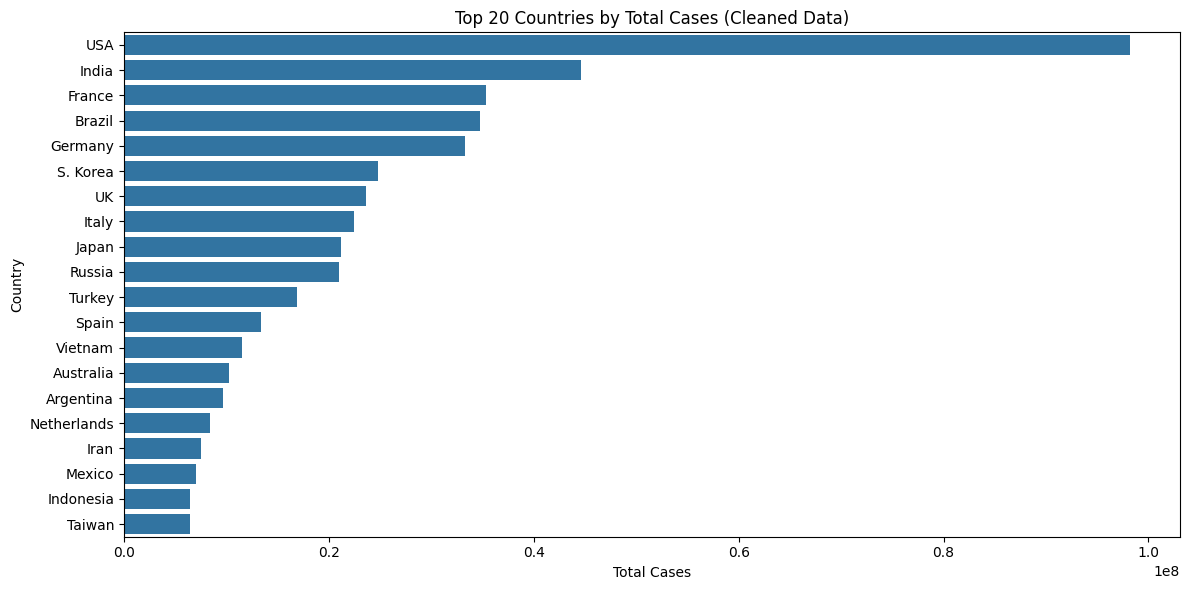

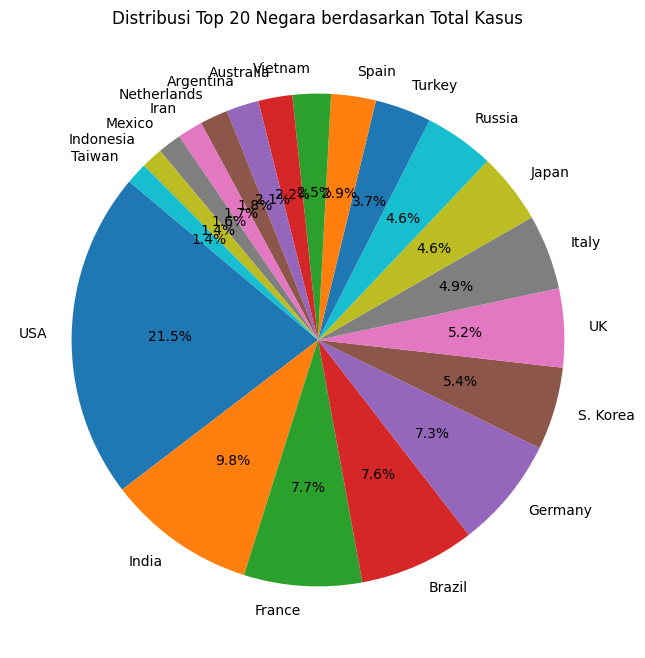

In [ ]:
import pandas as pd

df_raw = pd.read_csv("/content/drive/MyDrive/DATA_MINING/Covid_Live.csv")
print(df_raw.shape)
print(df_raw.head(5))

df = df_raw.copy()
df.columns = df.columns.str.replace("\n","", regex=True).str.replace(",","", regex=True).str.strip()

# Rename kolom negara jadi "Country"
df = df.rename(columns={"CountryOther": "Country"})
print(df.columns.tolist())

# hapus koma di angka lalu ubah ke float
for col in df.columns:
    if col != "Country":
        df[col] = (df[col].astype(str)
                          .str.replace(",","")
                          .str.strip()
                          .replace({"N/A": None, "-": None}))
        df[col] = pd.to_numeric(df[col], errors="coerce")

df = df[df['Country'].notna() & (df['Country'] != "")]

import matplotlib.pyplot as plt
import seaborn as sns

# ambil top 20 negara dengan kasus terbanyak
top20 = df.sort_values('TotalCases', ascending=False).head(20)

plt.figure(figsize=(12,6))
sns.barplot(data=top20, x='TotalCases', y='Country')
plt.title("Top 20 Countries by Total Cases (Cleaned Data)")
plt.xlabel("Total Cases")
plt.ylabel("Country")
plt.tight_layout()
plt.show()

# Alternatif pie chart
plt.figure(figsize=(8,8))
plt.pie(top20['TotalCases'], labels=top20['Country'], autopct='%1.1f%%', startangle=140)
plt.title("Distribusi Top 20 Negara berdasarkan Total Kasus")
plt.show()


In [ ]:
output_path = "/content/drive/MyDrive/DATA_MINING/covid_cleaned.csv"
df.to_csv(output_path, index=False)
print("Dataset hasil cleansing disimpan di:", output_path)

Dataset hasil cleansing disimpan di: /content/drive/MyDrive/DATA_MINING/covid_cleaned.csv


# **Ringkasan**


Bagian terakhir ini menyajikan informasi ringkas dari dataset yang sudah dibersihkan. Di sini dihitung jumlah negara yang ada dalam dataset, total kasus, total kematian, serta negara dengan kasus dan kematian terbanyak. Ringkasan ini penting sebagai kesimpulan dari proses data cleansing yang telah dilakukan.

In [ ]:
total_countries = df['Country'].nunique()
total_cases = int(df['TotalCases'].sum(skipna=True))
total_deaths = int(df['TotalDeaths'].sum(skipna=True))

most_cases = df.loc[df['TotalCases'].idxmax(), 'Country']
most_deaths = df.loc[df['TotalDeaths'].idxmax(), 'Country']

print(f"""
=== RINGKASAN DATASET COVID BERSIH ===
Jumlah Negara     : {total_countries}
Total Kasus       : {total_cases:,}
Total Kematian    : {total_deaths:,}
Kasus terbanyak   : {most_cases}
Kematian terbanyak: {most_deaths}
""")


=== RINGKASAN DATASET COVID BERSIH ===
Jumlah Negara     : 230
Total Kasus       : 622,372,853
Total Kematian    : 6,547,095
Kasus terbanyak   : USA
Kematian terbanyak: USA

